In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import subplots
import os

## 1 - Data

### 1.1 Data Loading

Data was retrieved from Wharton Research Data Services.  Namely Accounting/fundamental annual data was downloaded from CRSP/Compustat Merged, monthly stock return and stock information of U.S. stock market was downloaded from CRSP.   During this section we are just creating/merging the dataframes according to the PERMNO (company indentifier).

In [389]:
stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)
stk_data['PRC'] = abs(stk_data['PRC'])
stk_data['MktCap_Mon'] = stk_data['PRC']*stk_data['SHROUT'] 
stk_data['date'] = pd.to_datetime(stk_data['date'], format='%Y-%m-%d')
stk_data['Year'] = stk_data['date'].dt.strftime('%Y')
stk_data['date'] = stk_data['date'].dt.strftime('%Y-%m')
stk_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1290/1407839232.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10001,1989-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.50000,0.019608,998.0,0.066101,6.487000e+03,1989
1,10001,1989-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.038462,998.0,-0.016442,6.736500e+03,1989
2,10001,1989-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.017778,998.0,0.021465,6.736500e+03,1989
3,10001,1989-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.25000,0.074074,998.0,0.048207,7.235500e+03,1989
4,10001,1989-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.00000,-0.034483,998.0,0.039336,6.986000e+03,1989
...,...,...,...,...,...,...,...,...,...,...,...,...
3235104,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3235105,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3235106,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3235107,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


In [339]:
FF_data = pd.read_csv("Data/F&F_Factors.csv")
FF_data.index = FF_data['dateff']
FF_data = FF_data.drop("dateff", axis=1)
FF_data.index = pd.to_datetime(FF_data.index, format="%Y-%m-%d").to_period('M')
FF_data.rename_axis('date', inplace=True)

In [340]:
Acc_Data = pd.read_csv("Data/Acc_Data2.csv", header=0)
Acc_Data = Acc_Data.rename(columns={'LPERMNO': 'PERMNO'})
Acc_Data = Acc_Data.rename(columns={'datadate': 'date'})
Acc_Data.drop_duplicates(subset=['PERMNO', 'date'], inplace=True, ignore_index=True)
Acc_Data['date'] = pd.to_datetime(Acc_Data['date'])
Acc_Data['date'] = Acc_Data['date'].dt.year
Acc_Data.sort_values(by=['PERMNO','date'])

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt
86969,12994,1987,INDL,C,D,STD,USD,5.4178,2.750,NaN,0.32,5.369,I,LC,10001,1987-06-30
86970,12994,1988,INDL,C,D,STD,USD,5.5565,2.555,NaN,0.57,5.512,I,LC,10001,1988-06-30
86971,12994,1989,INDL,C,D,STD,USD,6.3147,7.370,NaN,1.21,6.321,I,LC,10001,1989-06-30
86972,12994,1990,INDL,C,D,STD,USD,6.9631,7.175,NaN,1.10,7.179,I,LC,10001,1990-06-29
86973,12994,1991,INDL,C,D,STD,USD,7.4390,6.965,NaN,1.01,7.982,I,LC,10001,1991-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230345,184996,2019,INDL,C,D,STD,USD,36.5635,12627.000,14697.0,-4.92,6618.000,A,LC,93436,2019-12-31
230346,184996,2020,INDL,C,D,STD,USD,23.1510,10888.000,13347.0,0.64,22225.000,A,LC,93436,2020-12-31
230347,184996,2021,INDL,C,D,STD,USD,29.2246,6916.000,8873.0,4.90,30189.000,A,LC,93436,2021-12-31
230348,184996,2022,INDL,C,D,STD,USD,14.1290,3761.000,5748.0,3.62,44704.000,A,LC,93436,2022-12-30


# 2 - Strategies Evaluation

## 2.1 Quality Strategy

### 2.1.1 Defining Quality Score

Quality score is built based on the MSCI quality index metodology (see below some links for information from MSCI)  Here we construct the Return on Equity and the Debt to equity components.  Below there is a function for the EVAR. 

https://www.msci.com/documents/1296102/8473352/Quality-brochure.pdf  https://www.msci.com/documents/10199/96bc76ad-a6cf-477c-a967-9b0132146b90  https://www.msci.com/eqb/methodology/meth_docs/MSCI_Fundamental_Data_Methodology_Mar2020.pdf  https://www.msci.com/eqb/methodology/meth_docs/MSCI_Jun17_Fundamental_Data.pdf 

In [341]:
Acc_Data['ROE'] = Acc_Data['epsfi']/Acc_Data['bkvlps']
Acc_Data['DtE_Rat'] = Acc_Data['dltt']/Acc_Data['seq']
Acc_Data

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
0,1001,1985,INDL,C,D,STD,USD,3.2633,11.908,NaN,0.68,13.014,I,LU,10015,1985-12-31,0.208378,0.915015
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236390,347085,2023,INDL,C,D,STD,USD,4.6842,5.786,9.844,1.05,144.982,A,LC,21069,2023-02-28,0.224158,0.039908
236391,348615,2023,INDL,C,D,STD,USD,2.9612,4.795,11.642,-0.48,97.590,A,LC,23424,2023-12-29,-0.162096,0.049134
236392,348892,2022,INDL,C,D,STD,USD,0.5382,3.109,3.503,-2.26,7.883,A,LC,20846,2022-12-30,-4.199182,0.394393
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [342]:
Quality_df = Acc_Data
company_years = Quality_df.groupby('PERMNO')['date'].nunique()
companies_with_5_years = company_years[company_years >= 5].index
companies_with_5_years

Acc_data_filtered = Acc_Data[Acc_Data['PERMNO'].isin(companies_with_5_years)]
Acc_data_filtered

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [343]:
def calculate_evar(group):
    if len(group) > 4:
        group['EPSg'] = group['epsfi'].pct_change() * 100
        group.loc[4:, 'EVAR'] = group['EPSg'].rolling(window=4).std(ddof=1)
        
    else:
        group['EVAR'] = 0
        
    return group

In [344]:
Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)
Acc_data_filtered

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1290/3759281452.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)


,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat,EPSg,EVAR
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476,NaN,NaN
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816,233.333333,NaN
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734,-76.666667,NaN
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082,-4271.428571,NaN
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692,-97.260274,2150.937866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486,12.500000,77.771864
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699,16.853933,30.756963
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890,10.576923,31.164466
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000,-57.598039,109.489869


This function builds the quality factor given Return on equity, debt to equity and Earnings variability. Conditions also defined by MSCI.

In [345]:
def Q_score(df):
    mean_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].mean()
    std_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].std()

    df = df.merge(mean_per_year, on='date', suffixes=('', '_mean'))
    df = df.merge(std_per_year, on='date', suffixes=('', '_std'))

    df['ROE Z-Score'] = (df['ROE'] - df['ROE_mean']) / df['ROE_std']
    df['DtE_Rat Z-Score'] = (df['DtE_Rat'] - df['DtE_Rat_mean']) / df['DtE_Rat_std']
    df['EVAR Z-Score'] = (df['EVAR'] - df['EVAR_mean']) / df['EVAR_std']

    df['Quality Z-Score'] = df[['ROE Z-Score', 'DtE_Rat Z-Score', 'EVAR Z-Score']].mean(axis=1)
    
    conditions = [
        (df['ROE'].isnull()), # If ROE is missing
        (df['DtE_Rat'].isnull()) & (~df['EVAR'].isnull()), # If only DtE_Rat is missing
        (~df['DtE_Rat'].isnull()) & (df['EVAR'].isnull()), # If only EVAR is missing
        (df[['ROE', 'DtE_Rat', 'EVAR']].isnull().sum(axis=1) >= 2) # If more than 2 values are missing
    ]
    choices = [
        np.nan, # If ROE is missing
        (df['ROE Z-Score'] + df['EVAR Z-Score']) / 2, # If only DtE_Rat is missing
        (df['ROE Z-Score'] + df['DtE_Rat Z-Score']) / 2, # If only EVAR is missing
        np.nan # If more than 2 values are missing
    ]
    df['Quality Z-Score'] = np.select(conditions, choices, default=df['Quality Z-Score'])

    df['Quality Score'] = df['Quality Z-Score'].apply(lambda x: (1 + x) if x >= 0 else (1 - x)**(-1) if not np.isnan(x) else np.nan)
    
    return df

In [346]:
Quality_df = Acc_data_filtered
Quality_df = Q_score(Quality_df)
Quality_df['date'] = pd.to_datetime(Quality_df['date'], format= "%Y")
Quality_df['date'] = Quality_df['date'].dt.strftime('%Y')
Quality_df = Quality_df[['date', 'PERMNO', 'Quality Score']]
Quality_df.rename(columns={'date': 'Year'}, inplace=True)
Quality_df

,Year,PERMNO,Quality Score
0,1986,10031,1.004270
1,1986,54594,0.961659
2,1986,10066,0.842079
3,1986,10074,1.122387
4,1986,10082,0.955472
...,...,...,...
215501,2023,15920,0.917093
215502,2023,17676,0.980181
215503,2023,18144,0.932924
215504,2023,14615,0.898050


Now, we are going to merge the 2 datasets:

* Monthly stock returns (with montly market cap): "stk_data"
* Yearly deciles sorting: "Quality_df"

In [347]:
merged_df = pd.merge(stk_data, Quality_df, on=['Year', 'PERMNO'], how='left')
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df.drop(columns=['Year'], inplace=True)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score
12,10001,1991-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.62500,0.013158,1054.0,0.049083,1.014475e+04,0.912553
13,10001,1991-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,0.012987,1054.0,0.075848,1.027650e+04,0.912553
14,10001,1991-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.50000,-0.011538,1054.0,0.028922,1.001300e+04,0.912553
15,10001,1991-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.039474,1054.0,0.003311,1.040825e+04,0.912553
16,10001,1991-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1054.0,0.040737,1.040825e+04,0.912553
...,...,...,...,...,...,...,...,...,...,...,...,...
3154219,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,0.979029
3154220,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,0.979029
3154221,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,0.979029
3154222,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,0.979029


Now we perform the basic data cleaning suggested by Prof. Smajlbegovic in the weekly assignment n.2.
* Selecting only common stocks
* Selecting only stocks listed on the NYSE, NASDAQ or AMEX
* Selecting only non financial firms

**Note:** observations that do not have returns data are removed from the dataset.

In [348]:
merged_df = merged_df[(merged_df['SHRCD'] == 10) | (merged_df['SHRCD'] == 11)] # Selecting only common stock
merged_df = merged_df[(merged_df['EXCHCD'] == 1) | (merged_df['EXCHCD'] == 2) | (merged_df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
merged_df['SICCD'] = pd.to_numeric(merged_df['SICCD'], errors='coerce')  
merged_df = merged_df[(merged_df['SICCD'] < 6000) | (merged_df['SICCD'] > 6999)]  # Removing financial firms stocks

In [349]:
merged_df['RET'] = pd.to_numeric(merged_df['RET'], errors='coerce')
merged_df = merged_df.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%Y-%m-%d')

In [367]:
def preprocess_dataframe(df):
    df = df[(df['SHRCD'] == 10) | (df['SHRCD'] == 11)] # Selecting only common stock
    df = df[(df['EXCHCD'] == 1) | (df['EXCHCD'] == 2) | (df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
    df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')  
    
    df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
    df = df.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

    return df

In [351]:
merged_df = preprocess_dataframe(merged_df)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score
12,10001,1991-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.62500,0.013158,1054.0,0.049083,1.014475e+04,0.912553
13,10001,1991-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,0.012987,1054.0,0.075848,1.027650e+04,0.912553
14,10001,1991-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.50000,-0.011538,1054.0,0.028922,1.001300e+04,0.912553
15,10001,1991-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.039474,1054.0,0.003311,1.040825e+04,0.912553
16,10001,1991-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1054.0,0.040737,1.040825e+04,0.912553
...,...,...,...,...,...,...,...,...,...,...,...,...
3154219,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,0.979029
3154220,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,0.979029
3154221,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,0.979029
3154222,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,0.979029


### 2.1.2 Deciles Portfolios Sorting

Following the metodology of the paper "Quality minus junk" we create 10 value-weighted deciles based on the quality score computed before.

In [352]:
merged_df = merged_df.sort_values(by='Quality Score', ascending=False)
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df['deciles_Q'] = merged_df.groupby(['date'])['Quality Score'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score,deciles_Q
1877458,80039,1999-04-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.87500,0.081448,18463.0,0.049092,551582.1250,43.836353,10
1877463,80039,1999-09-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,25.25000,0.094851,19269.0,-0.022669,486542.2500,43.836353,10
1877460,80039,1999-06-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.43750,0.015086,18603.0,0.050823,547625.8125,43.836353,10
1877459,80039,1999-05-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.00000,-0.029289,18463.0,-0.020708,535427.0000,43.836353,10
1877462,80039,1999-08-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,23.06250,-0.112981,18603.0,-0.009918,429031.6875,43.836353,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837992,79706,1997-01-01,11.0,3.0,7370.0,I V I PUBLISHING INC,3.37500,0.058824,7612.0,0.053473,25690.5000,0.031456,1
1837993,79706,1997-02-01,11.0,3.0,7370.0,I V I PUBLISHING INC,3.21875,-0.046296,7612.0,-0.001067,24501.1250,0.031456,1
1837999,79706,1997-08-01,11.0,3.0,7370.0,I V I PUBLISHING INC,2.62500,-0.222222,7663.0,-0.036323,20115.3750,0.031456,1
1837994,79706,1997-03-01,11.0,3.0,7370.0,I V I PUBLISHING INC,2.87500,-0.106796,7663.0,-0.044889,22031.1250,0.031456,1


### 2.1.3 Deciles Portfolios Returns

Here we are computing the value-weighted returns (based on the market cap)

In [398]:
def compute_deciles_port(merged_df):
    copy = merged_df.copy()
    
    grouped = copy.groupby(['date', 'deciles_Q'])

    copy['Total_MktCap_Month_Decile'] = grouped['MktCap_Mon'].transform('sum')
    copy['Weight_Decile'] = copy['MktCap_Mon'] / copy['Total_MktCap_Month_Decile']
    copy['Weighted_RET_Decile'] = copy['RET'] * copy['Weight_Decile']

    portfolio_df = pd.pivot_table(copy, values='Weighted_RET_Decile', index='date', columns='deciles_Q', aggfunc='sum')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [354]:
#copy = merged_df.copy()
    
#grouped = copy.groupby(['date', 'decile_Q'])

#copy['Total_MktCap_Month_Decile'] = grouped['MktCap_Mon'].transform('sum')
#copy['Weight_Decile'] = copy['MktCap_Mon'] / copy['Total_MktCap_Month_Decile']
#copy['Weighted_RET_Decile'] = copy['RET'] * copy['Weight_Decile']

#test = copy[(copy['date'].dt.year == 1993) & (copy['date'].dt.month == 3)]
#test

In [355]:
#portfolio_df = pd.pivot_table(copy, values='Weighted_RET_Decile', index='date', columns='decile_Q', aggfunc='sum')
#portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
#portfolio_df

In [399]:
portfolio_df = compute_deciles_port(merged_df)
portfolio_df['H-L'] = portfolio_df['P10'] - portfolio_df['P1']
portfolio_df.index = pd.to_datetime(portfolio_df.index, format="%Y-%m-%d").to_period('M')
portfolio_df = portfolio_df["1990":]
portfolio_df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.053279,-0.056957,-0.064265,-0.060143,-0.065824,-0.046522,-0.061508,-0.077182,-0.048495,-0.091607,-0.038328
1990-02,0.003003,0.013152,0.011913,0.017908,0.041118,0.014310,0.044857,0.069855,0.022426,0.021209,0.018206
1990-03,0.028661,0.040634,0.028565,0.031565,0.031619,0.038605,0.018583,0.036051,0.018057,0.054652,0.025990
1990-04,-0.031154,-0.012468,-0.004386,-0.036278,-0.023440,-0.022506,-0.023236,-0.037174,-0.027807,-0.039451,-0.008297
1990-05,0.094494,0.101416,0.084414,0.088363,0.104601,0.127520,0.072662,0.078893,0.081649,0.083240,-0.011254
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.004204,-0.017205,-0.004817,0.012712,-0.028973,-0.020373,-0.026114,-0.024206,0.013005,0.005478,0.009682
2023-09,-0.041458,-0.046773,-0.059169,-0.043425,-0.061569,-0.055685,-0.021384,-0.035014,-0.056469,-0.061119,-0.019661
2023-10,-0.028474,0.025249,-0.035610,-0.021775,-0.010854,-0.018792,-0.050437,-0.095262,-0.000730,-0.029954,-0.001480


### 2.1.4 Returns Analysis

After forming the portfolios, we first compute excess returns (by subtracting the rf column of the FF data) and then merge the two dataframes in a single one.

In [400]:
rf = FF_data['rf']
portfolio_df = portfolio_df.sub(rf, axis=0)
portfolio_df

Quality_FF = pd.concat([portfolio_df, FF_data], axis=1)
Quality_FF = Quality_FF["1990":]
Quality_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.058979,-0.062657,-0.069965,-0.065843,-0.071524,-0.052222,-0.067208,-0.082882,-0.054195,-0.097307,-0.044028,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,-0.002697,0.007452,0.006213,0.012208,0.035418,0.008610,0.039157,0.064155,0.016726,0.015509,0.012506,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.022261,0.034234,0.022165,0.025165,0.025219,0.032205,0.012183,0.029651,0.011657,0.048252,0.019590,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.038054,-0.019368,-0.011286,-0.043178,-0.030340,-0.029406,-0.030136,-0.044074,-0.034707,-0.046351,-0.015197,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.087694,0.094616,0.077614,0.081563,0.097801,0.120720,0.065862,0.072093,0.074849,0.076440,-0.018054,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.008704,-0.021705,-0.009317,0.008212,-0.033473,-0.024873,-0.030614,-0.028706,0.008505,0.000978,0.005182,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.045758,-0.051073,-0.063469,-0.047725,-0.065869,-0.059985,-0.025684,-0.039314,-0.060769,-0.065419,-0.023961,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.033174,0.020549,-0.040310,-0.026475,-0.015554,-0.023492,-0.055137,-0.099962,-0.005430,-0.034654,-0.006180,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


Plotting the cumulative returns of long-short quality factor vs. market benchmark:

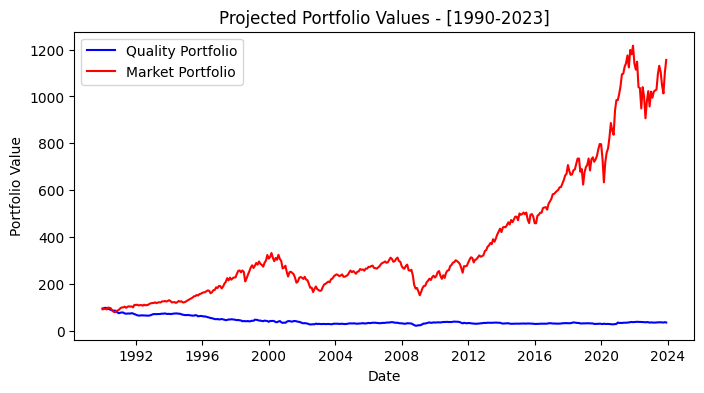

In [401]:
cumulative_returns1 = (1 + Quality_FF['H-L']).cumprod() 
cumulative_returns2 = (1 + Quality_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

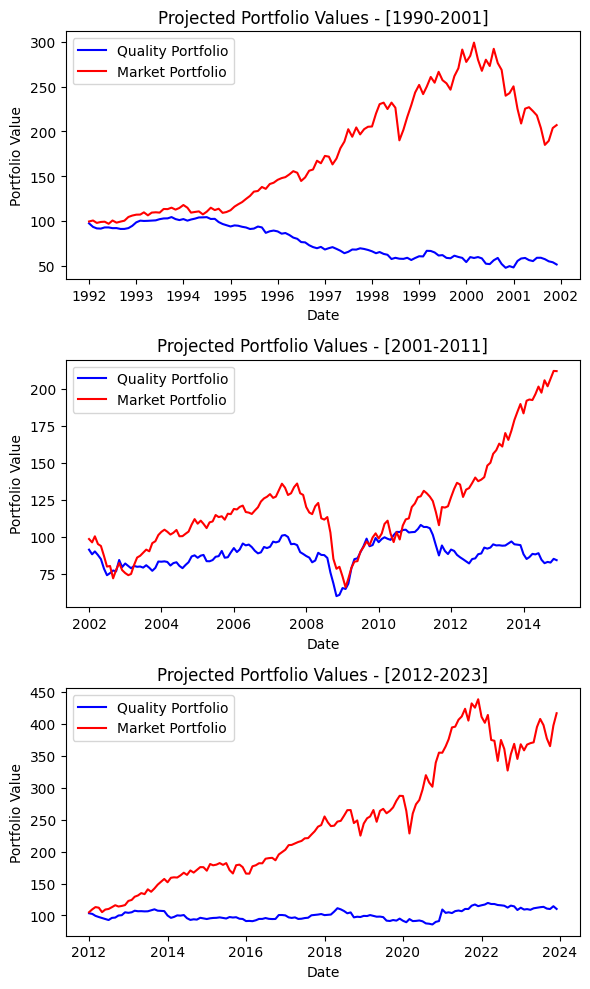

In [402]:
cumulative_returns1_1 = (1 + Quality_FF['H-L']['1992':'2001']).cumprod()
cumulative_returns2_1 = (1 + Quality_FF['mktrf']['1992':'2001']).cumprod()

cumulative_returns1_1.index = cumulative_returns1_1.index.to_timestamp()
cumulative_returns2_1.index = cumulative_returns2_1.index.to_timestamp()

initial_value = 100

portfolio_value1_1 = cumulative_returns1_1 * initial_value
portfolio_value2_1 = cumulative_returns2_1 * initial_value

cumulative_returns1_2 = (1 + Quality_FF['H-L']['2002':'2014']).cumprod()
cumulative_returns2_2 = (1 + Quality_FF['mktrf']['2002':'2014']).cumprod()

cumulative_returns1_2.index = cumulative_returns1_2.index.to_timestamp()
cumulative_returns2_2.index = cumulative_returns2_2.index.to_timestamp()

portfolio_value1_2 = cumulative_returns1_2 * initial_value
portfolio_value2_2 = cumulative_returns2_2 * initial_value

cumulative_returns1_3 = (1 + Quality_FF['H-L']['2012':]).cumprod()
cumulative_returns2_3 = (1 + Quality_FF['mktrf']['2012':]).cumprod() 

cumulative_returns1_3.index = cumulative_returns1_3.index.to_timestamp()
cumulative_returns2_3.index = cumulative_returns2_3.index.to_timestamp()

portfolio_value1_3 = cumulative_returns1_3 * initial_value
portfolio_value2_3 = cumulative_returns2_3 * initial_value

# Create subplots
fig, axs = plt.subplots(3, figsize=(6, 10))

# Plot each graph on its respective subplot
axs[0].plot(portfolio_value1_1, color='blue', linestyle='-', label='Quality Portfolio')
axs[0].plot(portfolio_value2_1, color='red', linestyle='-', label='Market Portfolio')
axs[0].set_title('Projected Portfolio Values - [1990-2001]')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Portfolio Value')
axs[0].legend()

axs[1].plot(portfolio_value1_2, color='blue', linestyle='-', label='Quality Portfolio')
axs[1].plot(portfolio_value2_2, color='red', linestyle='-', label='Market Portfolio')
axs[1].set_title('Projected Portfolio Values - [2001-2011]')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Portfolio Value')
axs[1].legend()

axs[2].plot(portfolio_value1_3, color='blue', linestyle='-', label='Quality Portfolio')
axs[2].plot(portfolio_value2_3, color='red', linestyle='-', label='Market Portfolio')
axs[2].set_title('Projected Portfolio Values - [2012-2023]')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Portfolio Value')
axs[2].legend()

plt.tight_layout()
plt.show()


### 2.1.5 Regressions Quality

**1) CAPM**

In [403]:
def CAPM_regression(portfolio_df, Quality_FF):
    factors_CAPM = Quality_FF['mktrf']
    regression_results_CAPM = pd.DataFrame(index=['Alpha CAPM', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_CAPM = sm.add_constant(factors_CAPM)

        model = sm.OLS(portfolio_returns, X_CAPM)
        results = model.fit()

        regression_results_CAPM.loc['Alpha CAPM', portfolio] = results.params[0]
        regression_results_CAPM.loc['Alpha t-stat', portfolio] = results.tvalues[0]
        regression_results_CAPM.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_CAPM.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_CAPM.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_CAPM

In [404]:
CAPM_Quality = CAPM_regression(portfolio_df,Quality_FF)
CAPM_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.007949,0.007131,0.006906,0.005648,0.006585,0.009386,0.011273,0.011105,0.007201,0.006793,-0.003308
Alpha t-stat,7.145419,6.718976,8.955142,6.463379,6.677045,9.48033,6.899441,9.123896,4.884773,5.212691,-1.95406
β_Mkt-RF,0.95215,0.959188,0.887975,0.974068,0.962017,0.980167,1.154061,1.098931,1.178094,1.148766,0.198583
Mkt-RF t-stat,38.540127,40.692373,51.849506,50.193424,43.922741,44.57782,31.805457,40.654719,35.984517,39.694268,5.281492
Adj.R2,0.784809,0.802606,0.868471,0.860873,0.825711,0.829934,0.712892,0.802313,0.760713,0.794614,0.061983


**2) FF-3**

In [405]:
def FF3_regression(portfolio_df, Quality_FF):
    factors_FF3 = Quality_FF[['mktrf', 'smb', 'hml']]
    regression_results_FF3 = pd.DataFrame(index=['Alpha FF3', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML',  'HML t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF3 = sm.add_constant(factors_FF3)

        model = sm.OLS(portfolio_returns, X_FF3)
        results = model.fit()

        regression_results_FF3.loc['Alpha FF3', portfolio] = results.params[0] 
        regression_results_FF3.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_FF3.loc['β_SMB', portfolio] = results.params[2]
        regression_results_FF3.loc['β_HML', portfolio] = results.params[3]
        
        regression_results_FF3.loc['Alpha t-stat', portfolio] = results.tvalues[0] 
        regression_results_FF3.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_FF3.loc['SMB t-stat', portfolio] = results.tvalues[2]
        regression_results_FF3.loc['HML t-stat', portfolio] = results.tvalues[3]

        regression_results_FF3.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF3

In [407]:
FF3_Quality = FF3_regression(portfolio_df, Quality_FF)
FF3_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.00825,0.007541,0.007017,0.005736,0.006707,0.009264,0.011485,0.011169,0.007369,0.006799,-0.003603
Alpha t-stat,7.577216,7.575248,9.178226,6.559273,6.835795,9.47055,7.497259,9.786607,5.4674,5.272699,-2.167313
β_Mkt-RF,0.943913,0.96252,0.892874,0.97195,0.947164,0.968594,1.083056,1.047938,1.104921,1.123572,0.180922
Mkt-RF t-stat,37.733038,42.080847,50.832319,48.374769,42.013237,43.096068,30.772832,39.964258,35.678551,37.925348,4.737277
β_SMB,-0.023507,-0.119162,-0.056209,-0.008635,0.059372,0.098845,0.37407,0.28995,0.397582,0.14948,0.177005
SMB t-stat,-0.649836,-3.602663,-2.212935,-0.297211,1.821174,3.041332,7.349895,7.646641,8.877971,3.489178,3.205041
β_HML,-0.150631,-0.202628,-0.05418,-0.044035,-0.063179,0.058495,-0.117174,-0.040492,-0.095981,-0.007266,0.142846
HML t-stat,-4.562738,-6.712662,-2.337257,-1.660703,-2.123499,1.972126,-2.522723,-1.170096,-2.348454,-0.185853,2.834176
Adj.R2,0.794617,0.826976,0.8712,0.86117,0.828104,0.834587,0.748544,0.826822,0.800684,0.799641,0.099112


**3) FF-5**

In [408]:
def FF5_regression(portfolio_df, Quality_FF):
    factors_FF5 = Quality_FF[['mktrf', 'smb', 'hml', 'rmw', 'cma']]
    regression_results_FF5 = pd.DataFrame(index=['Alpha FF5', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML', 'HML t-stat', 'β_RMW', 'RMW t-stat', 'β_CMA', 'CMA t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF5 = sm.add_constant(factors_FF5)

        model = sm.OLS(portfolio_returns, X_FF5)
        results = model.fit()

        regression_results_FF5.loc['Alpha FF5', portfolio] = results.params[0] 
        regression_results_FF5.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_FF5.loc['β_SMB', portfolio] = results.params[2]
        regression_results_FF5.loc['β_HML', portfolio] = results.params[3]
        regression_results_FF5.loc['β_RMW', portfolio] = results.params[4]
        regression_results_FF5.loc['β_CMA', portfolio] = results.params[5]
        
        regression_results_FF5.loc['Alpha t-stat', portfolio] = results.tvalues[0] 
        regression_results_FF5.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_FF5.loc['SMB t-stat', portfolio] = results.tvalues[2]
        regression_results_FF5.loc['HML t-stat', portfolio] = results.tvalues[3]
        regression_results_FF5.loc['RMW t-stat', portfolio] = results.tvalues[4]
        regression_results_FF5.loc['CMA t-stat', portfolio] = results.tvalues[5]

        regression_results_FF5.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF5

In [409]:
FF5_Quality = FF5_regression(portfolio_df, Quality_FF)
FF5_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.007918,0.007455,0.006031,0.004863,0.006062,0.008125,0.011858,0.011124,0.008617,0.007322,-0.002758
Alpha t-stat,7.010178,7.410636,7.960563,5.468807,6.208285,8.286272,7.470716,9.415971,6.51735,5.604935,-1.634155
β_Mkt-RF,0.951922,0.947065,0.91566,1.009743,0.990232,1.021021,1.078603,1.057979,1.091773,1.126975,0.176903
Mkt-RF t-stat,34.663058,38.719026,49.709019,46.69786,41.710012,42.826957,27.947088,36.82885,33.960696,35.481695,4.310076
β_SMB,0.001355,-0.068503,0.020019,0.014428,0.038391,0.121212,0.334669,0.270723,0.261642,0.070057,0.072741
SMB t-stat,0.03359,-1.906682,0.73989,0.454282,1.100944,3.461422,5.903603,6.415986,5.540865,1.501658,1.206579
β_HML,-0.168394,-0.140749,-0.103171,-0.154222,-0.201975,-0.097056,-0.114459,-0.076862,-0.093447,-0.039999,0.126068
HML t-stat,-3.624442,-3.40127,-3.310622,-4.215829,-5.028632,-2.406333,-1.752975,-1.581514,-1.718148,-0.744365,1.815535
β_RMW,0.070392,0.130169,0.215083,0.07797,-0.038606,0.082198,-0.108116,-0.047661,-0.372093,-0.212768,-0.282857
RMW t-stat,1.388448,2.882685,6.324851,1.953255,-0.880853,1.867617,-1.51743,-0.898708,-6.269603,-3.628608,-3.733014


## 2.2 - Momentum Strategy

In [411]:
stk_data

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10001,1989-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.50000,0.019608,998.0,0.066101,6.487000e+03,1989
1,10001,1989-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.038462,998.0,-0.016442,6.736500e+03,1989
2,10001,1989-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.017778,998.0,0.021465,6.736500e+03,1989
3,10001,1989-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.25000,0.074074,998.0,0.048207,7.235500e+03,1989
4,10001,1989-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.00000,-0.034483,998.0,0.039336,6.986000e+03,1989
...,...,...,...,...,...,...,...,...,...,...,...,...
3235104,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3235105,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3235106,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3235107,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


First of all we drop observations without returns data:

In [412]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

In [413]:
Momentum_df = stk_data
Momentum_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1290/3862814677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Momentum_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')


In [414]:
Momentum_df = preprocess_dataframe(Momentum_df)

### 2.2.1 Building "Momentum Score"

Momentum was built based on "Is momentum really momentum?" by Novy-Marx, Robert, (2012) where they find the biggest results regarding the MOM12-7, so the returns based on the 12th to 7th months prior. We experimented on two ways of builiding the mom factor through the growth rate and through the comulative sum (GR, CUM).

In [415]:
Momentum_df = Momentum_df.sort_values(by=['PERMNO', 'date'])

window_size = 12

Momentum_df['PRC_7M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size - 5)  # Price at 7 months prior
Momentum_df['PRC_12M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size)  # Price at 12 months prior

Momentum_df['MOM12-7(GR)'] = (Momentum_df['PRC_7M'] - Momentum_df['PRC_12M']) / Momentum_df['PRC_12M']

Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR)
0,10001,1989-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.50000,0.019608,998.0,0.066101,6.487000e+03,1989,NaN,NaN,NaN
1,10001,1989-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.038462,998.0,-0.016442,6.736500e+03,1989,NaN,NaN,NaN
2,10001,1989-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.017778,998.0,0.021465,6.736500e+03,1989,NaN,NaN,NaN
3,10001,1989-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.25000,0.074074,998.0,0.048207,7.235500e+03,1989,NaN,NaN,NaN
4,10001,1989-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.00000,-0.034483,998.0,0.039336,6.986000e+03,1989,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235104,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,173.22000,275.60999,-0.371503
3235105,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,205.71001,265.25000,-0.224467
3235106,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,207.46001,227.53999,-0.088248
3235107,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,164.31000,194.70000,-0.156086


In [416]:
Momentum_df =Momentum_df.sort_values(by=['PERMNO', 'date'])

def compute_rolling_sum(group):
    group['MOM12-7(CUM)'] = group['RET'].shift(7).rolling(window=6).sum()
    return group

Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)

Momentum_df

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1290/616378836.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR),MOM12-7(CUM)
0,10001,1989-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.50000,0.019608,998.0,0.066101,6.487000e+03,1989,NaN,NaN,NaN,NaN
1,10001,1989-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.038462,998.0,-0.016442,6.736500e+03,1989,NaN,NaN,NaN,NaN
2,10001,1989-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,0.017778,998.0,0.021465,6.736500e+03,1989,NaN,NaN,NaN,NaN
3,10001,1989-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.25000,0.074074,998.0,0.048207,7.235500e+03,1989,NaN,NaN,NaN,NaN
4,10001,1989-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,7.00000,-0.034483,998.0,0.039336,6.986000e+03,1989,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235104,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,173.22000,275.60999,-0.371503,-0.357671
3235105,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,205.71001,265.25000,-0.224467,-0.097617
3235106,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,207.46001,227.53999,-0.088248,-0.051521
3235107,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,164.31000,194.70000,-0.156086,-0.117345


### 2.2.2 Momentum Deciles Sorting

The deciles are created based on the comulative sum of the stock returns of the 12-7 months. 

In [417]:
Momentum_df = Momentum_df.sort_values(by='MOM12-7(CUM)', ascending=False)
Momentum_df.dropna(subset=['MOM12-7(CUM)'], inplace=True)
Momentum_df['deciles_Q'] = Momentum_df.groupby(['date'])['MOM12-7(CUM)'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR),MOM12-7(CUM),deciles_Q
1169463,58748,1992-08-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.68750,0.047619,16297.0,-0.020819,11204.1875,1992,1.17188,0.04688,23.997440,24.000000,10
1169464,58748,1992-09-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.53125,-0.227273,16822.0,0.012461,8936.6875,1992,1.14063,0.04688,23.330845,23.973333,10
1169465,58748,1992-10-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.50000,-0.058824,16822.0,0.010983,8411.0000,1992,0.79688,0.04688,15.998294,23.671963,10
1169466,58748,1992-11-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.75000,0.500000,16822.0,0.040181,12616.5000,1992,0.78125,0.04688,15.664889,23.652355,10
1169467,58748,1992-12-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.50000,-0.333333,17755.0,0.017740,8877.5000,1992,0.71875,0.04688,14.331698,23.572355,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325161,84521,2007-12-01,11.0,2.0,2836.0,CARDIUM THERAPEUTICS INC,2.60000,-0.018868,40935.0,-0.004405,106431.0000,2007,0.03125,4.59375,-0.993197,-3.116634,1
2729722,89169,2020-09-01,11.0,3.0,3841.0,DELCATH SYSTEMS INC,11.61000,-0.024370,4036.0,-0.035056,46857.9600,2020,0.02110,0.92000,-0.977065,-3.118186,1
3154169,92687,2017-09-01,11.0,3.0,8711.0,REAL GOODS SOLAR INC,0.87000,0.108280,7481.0,0.023729,6508.4700,2017,1.68000,3.81000,-0.559055,-3.276644,1
3141253,92571,2020-06-01,11.0,2.0,1311.0,CAMBER ENERGY INC,1.19000,-0.070312,12456.0,0.025299,14822.6400,2020,0.85610,0.15130,4.658295,-3.414555,1


### 2.2.3 Momentum Deciles Portfolios Returns

Portfolio returns based on momentum are also value-weighted (compute_deciles_port function does that). 

In [418]:
portfolio_mom = compute_deciles_port(Momentum_df)
portfolio_mom['H-L'] = portfolio_mom['P10'] - portfolio_mom['P1']
portfolio_mom.index = pd.to_datetime(portfolio_mom.index, format="%Y-%m-%d").to_period('M')
portfolio_mom = portfolio_mom['1990':]
portfolio_mom

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.040700,-0.027353,-0.017096,-0.052658,-0.054636,-0.056967,-0.070413,-0.090004,-0.114240,-0.114519,-0.073818
1990-02,0.089880,0.033453,0.054042,0.029255,0.015121,0.019096,0.009189,0.014788,0.016032,0.048793,-0.041087
1990-03,0.073587,0.041106,0.020868,0.010757,0.029603,0.012501,0.015744,0.039232,0.047887,0.047302,-0.026284
1990-04,-0.023316,-0.048627,-0.004806,-0.022953,-0.030936,-0.025884,-0.029030,-0.016535,-0.012472,-0.008755,0.014560
1990-05,0.073549,0.079779,0.082321,0.096076,0.082438,0.078050,0.092780,0.094752,0.113987,0.138167,0.064619
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.029304,-0.009949,-0.025613,-0.028455,-0.029694,-0.000218,-0.007193,-0.004659,-0.005593,-0.019768,0.009537
2023-09,-0.077207,-0.066241,-0.037485,-0.048601,-0.039308,-0.032532,-0.044476,-0.033402,-0.046614,-0.094457,-0.017251
2023-10,-0.135519,-0.068620,-0.043442,-0.026599,-0.003804,-0.023823,-0.022953,-0.000559,-0.027692,-0.045598,0.089921


We subtract risk free rate in order to have the excess returns.

In [419]:
portfolio_mom = portfolio_mom.sub(rf, axis=0)

Momentum_FF = pd.concat([portfolio_mom, FF_data], axis=1)
Momentum_FF = Momentum_FF['1990':]
Momentum_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.046400,-0.033053,-0.022796,-0.058358,-0.060336,-0.062667,-0.076113,-0.095704,-0.119940,-0.120219,-0.079518,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,0.084180,0.027753,0.048342,0.023555,0.009421,0.013396,0.003489,0.009088,0.010332,0.043093,-0.046787,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.067187,0.034706,0.014468,0.004357,0.023203,0.006101,0.009344,0.032832,0.041487,0.040902,-0.032684,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.030216,-0.055527,-0.011706,-0.029853,-0.037836,-0.032784,-0.035930,-0.023435,-0.019372,-0.015655,0.007660,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.066749,0.072979,0.075521,0.089276,0.075638,0.071250,0.085980,0.087952,0.107187,0.131367,0.057819,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.033804,-0.014449,-0.030113,-0.032955,-0.034194,-0.004718,-0.011693,-0.009159,-0.010093,-0.024268,0.005037,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.081507,-0.070541,-0.041785,-0.052901,-0.043608,-0.036832,-0.048776,-0.037702,-0.050914,-0.098757,-0.021551,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.140219,-0.073320,-0.048142,-0.031299,-0.008504,-0.028523,-0.027653,-0.005259,-0.032392,-0.050298,0.085221,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.2.4 Return Analysis

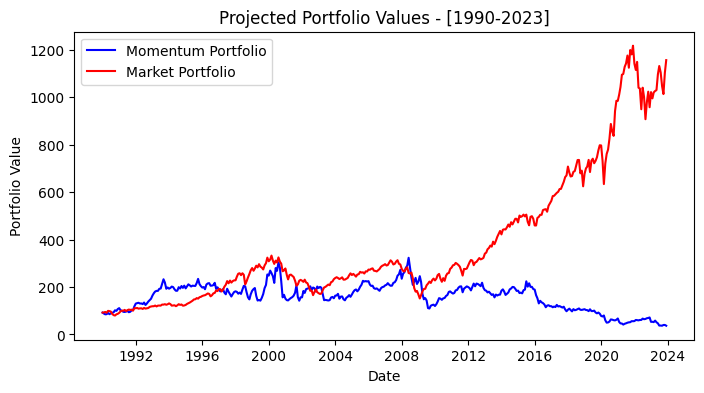

In [434]:
cumulative_returns1 = (1 + Momentum_FF['H-L']).cumprod() 
cumulative_returns2 = (1 + Momentum_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Momentum Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### 2.2.5 Regressions Momentum

**1) CAPM**

In [421]:
CAPM_MOM = CAPM_regression(portfolio_mom, Momentum_FF)
CAPM_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.015803,0.00585,0.006159,0.004487,0.005176,0.005754,0.006643,0.007691,0.00967,0.018971,0.001016
Alpha t-stat,5.434483,3.173619,4.319004,4.095527,5.373207,7.196121,7.750871,8.177234,6.853205,7.953759,0.275011
β_Mkt-RF,1.549585,1.178667,1.041734,0.991383,0.931466,0.88925,0.903134,0.945727,1.081337,1.456614,-0.091005
Mkt-RF t-stat,23.995238,28.792002,32.895814,40.746384,43.543351,50.075455,47.446528,45.273745,34.507333,27.49917,-1.109662
Adj.R2,0.585443,0.67044,0.726503,0.803027,0.823199,0.860308,0.84683,0.834264,0.745108,0.649803,0.000568


**2) FF-3**

In [422]:
FF3_MOM = FF3_regression(portfolio_mom, Momentum_FF)
FF3_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.015743,0.005428,0.005734,0.003938,0.00477,0.005372,0.006504,0.007822,0.010048,0.02014,0.002245
Alpha t-stat,5.861067,3.058533,4.143307,3.95362,5.279376,7.298523,7.638314,8.336048,7.564248,10.301039,0.629831
β_Mkt-RF,1.424297,1.151319,1.045901,1.026064,0.957178,0.911164,0.914472,0.942336,1.023665,1.299627,-0.123407
Mkt-RF t-stat,23.078386,28.234845,32.894799,44.838475,46.111972,53.882918,46.744354,43.70911,33.541996,28.931485,-1.506899
β_SMB,0.764885,0.265927,0.077864,-0.074857,-0.055787,-0.038709,-0.034163,-0.011291,0.254105,0.657451,-0.103417
SMB t-stat,8.57062,4.509863,1.693488,-2.262138,-1.858496,-1.582978,-1.207598,-0.362179,5.757782,10.121074,-0.873265
β_HML,0.008003,0.204463,0.211332,0.278149,0.205622,0.193351,0.071082,-0.065315,-0.19702,-0.606428,-0.61495
HML t-stat,0.098255,3.799482,5.036415,9.210321,7.506031,8.664058,2.753207,-2.295617,-4.89173,-10.229446,-5.689898
Adj.R2,0.64755,0.695617,0.743344,0.837798,0.845027,0.882085,0.849386,0.835657,0.77494,0.765543,0.072281


**3) FF-5**

In [423]:
FF5_MOM = FF5_regression(portfolio_mom,Momentum_FF)
FF5_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.018179,0.006261,0.005744,0.003488,0.004091,0.0046,0.005655,0.007203,0.010769,0.021639,0.001297
Alpha t-stat,6.600938,3.446795,4.048097,3.422569,4.412556,6.187709,6.508392,7.489981,7.916418,10.953786,0.351602
β_Mkt-RF,1.34594,1.100555,1.027383,1.029361,0.97466,0.929817,0.948765,0.972859,1.0134,1.276735,-0.067354
Mkt-RF t-stat,20.099672,24.916476,29.778247,41.539938,43.236023,51.439143,44.91188,41.604769,30.637918,26.580148,-0.75074
β_SMB,0.632215,0.280888,0.123126,-0.022219,-0.007843,0.018874,-0.00546,-0.004285,0.182199,0.511982,-0.116195
SMB t-stat,6.427694,4.329475,2.429646,-0.610441,-0.236862,0.710879,-0.175978,-0.12476,3.750162,7.256684,-0.881738
β_HML,0.212712,0.365327,0.281152,0.282707,0.165085,0.151897,-0.026728,-0.157561,-0.185463,-0.576488,-0.791528
HML t-stat,1.877612,4.888839,4.816788,6.74348,4.328612,4.967017,-0.747859,-3.982821,-3.314242,-7.094094,-5.214858
β_RMW,-0.390486,0.019163,0.114337,0.143331,0.136591,0.163076,0.091717,0.031633,-0.198202,-0.401856,-0.011067
RMW t-stat,-3.158729,0.23501,1.795131,3.133165,3.282154,4.886856,2.351766,0.732786,-3.245865,-4.531797,-0.066822


## 2.3 Low Volatility Strategy

In [ ]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_12722/115396609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')


In [ ]:
LowVol_df = stk_data
LowVol_df['date'] = pd.to_datetime(LowVol_df['date'], format='%Y-%m-%d')

In [ ]:
LowVol_df = preprocess_dataframe(LowVol_df)
LowVol_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


### 2.3.1 Building Low-Volatility Score

In [ ]:
LowVol_df = LowVol_df.sort_values(by=['PERMNO', 'date'])

def compute_rolling_sum(group):
    group['RET_VAR'] = group['RET'].rolling(window=36).var()
    return group

LowVol_df = LowVol_df.groupby('PERMNO').apply(compute_rolling_sum)
LowVol_df

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_12722/967580346.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  LowVol_df = LowVol_df.groupby('PERMNO').apply(compute_rolling_sum)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,RET_VAR
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987,NaN
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987,NaN
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987,NaN
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,0.038574
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,0.037853
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,0.038888
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,0.034263


### 2.3.2 Volatility Deciles Sorting

In the low vol strategy we follow the Blitz et al (2007) methodology considering the variance of the previous 36 months to rank stocks in deciles.

In [ ]:
LowVol_df = LowVol_df.sort_values(by='RET_VAR', ascending=True)
LowVol_df.dropna(subset=['RET_VAR'], inplace=True)
LowVol_df['deciles_Q'] = LowVol_df.groupby(['date'])['RET_VAR'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
LowVol_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,RET_VAR,deciles_Q
1130646,47504,1992-03-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,-0.023699,10530.00000,1992,0.000042,1
1130645,47504,1992-02-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,0.013355,10530.00000,1992,0.000048,1
1130644,47504,1992-01-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,-0.001164,10530.00000,1992,0.000048,1
1130643,47504,1991-12-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,0.106782,10530.00000,1991,0.000048,1
1130642,47504,1991-11-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,816.0,-0.037291,10608.00000,1991,0.000048,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277713,58748,1992-09-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.53125,-0.227273,16822.0,0.012461,8936.68750,1992,16.214424,10
1277711,58748,1992-07-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.65625,-0.045455,16297.0,0.039900,10694.90625,1992,16.215726,10
1277709,58748,1992-05-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.71875,-0.080000,16184.0,0.006407,11632.25000,1992,16.216260,10
1277710,58748,1992-06-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.68750,-0.043478,16297.0,-0.019258,11204.18750,1992,16.216646,10


### 2.3.3 Volatility Deciles Portfolios Returns

In [ ]:
portfolio_LowVol = compute_deciles_port(LowVol_df)
portfolio_LowVol['L-H'] = portfolio_LowVol['P1'] - portfolio_LowVol['P10']
portfolio_LowVol.index = pd.to_datetime(portfolio_LowVol.index, format="%Y-%m-%d").to_period('M')
portfolio_LowVol = portfolio_LowVol['1990':]
portfolio_LowVol

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
date,,,,,,,,,,,
1990-01,-0.066149,-0.056857,-0.075442,-0.094646,-0.083272,-0.043450,-0.060716,-0.107197,-0.092055,-0.020281,-0.045868
1990-02,-0.000580,0.018645,0.018146,0.033925,0.056635,0.050247,0.039728,0.076186,0.085640,0.164111,-0.164690
1990-03,0.016179,0.027949,0.030463,0.020599,0.043993,0.047576,0.063604,0.107147,0.125742,0.074551,-0.058372
1990-04,-0.015876,-0.022066,-0.027503,-0.022861,-0.031305,-0.035301,-0.036977,-0.034548,-0.007356,0.023633,-0.039509
1990-05,0.079613,0.087043,0.100736,0.112972,0.134549,0.108843,0.142103,0.127692,0.148033,0.147833,-0.068219
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.014466,-0.015662,0.002053,-0.003087,-0.022035,-0.044937,0.010982,-0.036284,-0.060193,-0.025635,0.011169
2023-09,-0.032151,-0.052670,-0.036844,-0.057010,-0.047422,-0.041517,-0.089924,-0.037931,-0.041302,-0.044870,0.012719
2023-10,0.008532,-0.021987,-0.032615,-0.012368,-0.059612,-0.032618,-0.061470,-0.165042,-0.103131,-0.099820,0.108352


In [ ]:
portfolio_LowVol = portfolio_LowVol.sub(rf, axis=0)
LowVol_FF = pd.concat([portfolio_LowVol, FF_data], axis=1)
LowVol_FF = LowVol_FF['1990':]
LowVol_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.071849,-0.062557,-0.081142,-0.100346,-0.088972,-0.049150,-0.066416,-0.112897,-0.097755,-0.025981,-0.051568,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,-0.006280,0.012945,0.012446,0.028225,0.050935,0.044547,0.034028,0.070486,0.079940,0.158411,-0.170390,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.009779,0.021549,0.024063,0.014199,0.037593,0.041176,0.057204,0.100747,0.119342,0.068151,-0.064772,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.022776,-0.028966,-0.034403,-0.029761,-0.038205,-0.042201,-0.043877,-0.041448,-0.014256,0.016733,-0.046409,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.072813,0.080243,0.093936,0.106172,0.127749,0.102043,0.135303,0.120892,0.141233,0.141033,-0.075019,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.018966,-0.020162,-0.002447,-0.007587,-0.026535,-0.049437,0.006482,-0.040784,-0.064693,-0.030135,0.006669,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.036451,-0.056970,-0.041144,-0.061310,-0.051722,-0.045817,-0.094224,-0.042231,-0.045602,-0.049170,0.008419,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,0.003832,-0.026687,-0.037315,-0.017068,-0.064312,-0.037318,-0.066170,-0.169742,-0.107831,-0.104520,0.103652,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


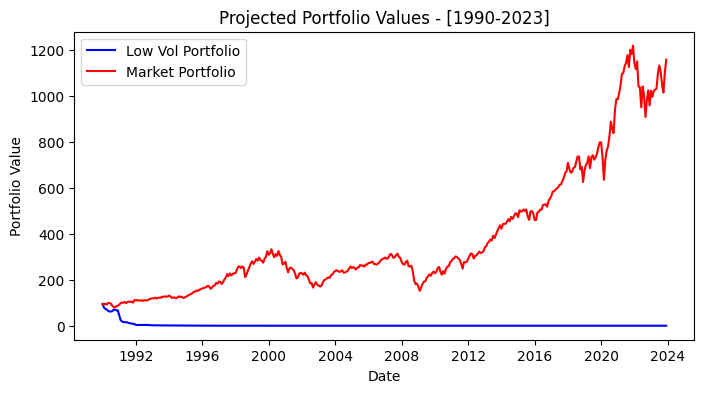

In [ ]:
cumulative_returns1 = (1 + LowVol_FF['L-H']).cumprod() 
cumulative_returns2 = (1 + LowVol_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Low Vol Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### 2.3.4 Regressions Low Vol

**1) CAPM**

In [ ]:
CAPM_LOWVOL = CAPM_regression(portfolio_LowVol, LowVol_FF)
CAPM_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha CAPM,0.004945,0.003716,0.006591,0.00767,0.006236,0.011598,0.014376,0.016388,0.026084,0.059173,-0.05638
Alpha t-stat,5.594833,4.330312,6.932662,7.890337,5.180718,7.368365,7.498177,5.9083,6.67334,7.283754,-6.627114
β_Mkt-RF,0.571247,0.858781,1.008867,1.18018,1.35066,1.462926,1.564792,1.839925,2.055728,2.280646,-1.707433
Mkt-RF t-stat,29.102903,45.059903,47.785665,54.67106,50.525331,41.850716,36.750818,29.868435,23.681604,12.640725,-9.03696
Adj.R2,0.675174,0.83295,0.848669,0.880115,0.862445,0.811354,0.768305,0.68647,0.579032,0.280649,0.165414


**2) FF-3**

In [ ]:
FF3_LOWVOL = FF3_regression(portfolio_LowVol, LowVol_FF)
FF3_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha FF3,0.004666,0.003237,0.006167,0.007278,0.006422,0.011824,0.014879,0.017203,0.027347,0.060438,-0.057924
Alpha t-stat,6.418955,4.655651,7.096634,7.918837,5.735675,8.308881,8.855052,7.330707,8.16566,8.441029,-7.912844
β_Mkt-RF,0.632978,0.913571,1.04628,1.188823,1.295441,1.380108,1.450812,1.658005,1.809129,1.810234,-1.175993
Mkt-RF t-stat,37.903073,57.196803,52.405946,56.301307,50.356835,42.209834,37.578607,30.750778,23.510953,11.003906,-6.99208
β_SMB,-0.302192,-0.212135,-0.121532,0.043082,0.285782,0.441334,0.560865,0.892623,1.171564,2.511852,-2.810026
SMB t-stat,-12.513523,-9.184435,-4.209551,1.410925,7.682234,9.334243,10.046136,11.448524,10.528784,10.558871,-11.553759
β_HML,0.149013,0.247125,0.216525,0.195776,-0.101609,-0.126359,-0.269216,-0.434907,-0.66824,-0.707375,0.855869
HML t-stat,6.761296,11.72376,8.21791,7.025581,-2.992917,-2.928377,-5.283853,-6.112058,-6.58042,-3.258232,3.855932
Adj.R2,0.781119,0.890779,0.874022,0.893221,0.881416,0.846358,0.82267,0.776402,0.692076,0.443264,0.384355


**3) FF-5**

In [ ]:
FF5_LOWVOL = FF5_regression(portfolio_LowVol,LowVol_FF)
FF5_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha FF5,0.00265,0.001559,0.004805,0.007207,0.007004,0.013709,0.017171,0.021072,0.032433,0.066588,-0.0661
Alpha t-stat,4.058826,2.444446,5.814843,7.753675,6.145874,9.545311,10.184785,9.056103,9.844029,9.307501,-9.095411
β_Mkt-RF,0.706545,0.962441,1.074078,1.174485,1.259017,1.317387,1.358608,1.531253,1.676887,1.724679,-1.016284
Mkt-RF t-stat,44.498232,62.069587,53.456375,51.968775,45.438197,37.724117,33.140911,27.064813,20.932143,9.91447,-5.751211
β_SMB,-0.214424,-0.107884,-0.007043,0.0888,0.298723,0.343878,0.482529,0.687569,0.815495,1.893914,-2.1043
SMB t-stat,-9.19398,-4.736849,-0.238629,2.675067,7.339806,6.704053,8.013465,8.273718,6.930393,7.412216,-8.107342
β_HML,-0.053479,0.12547,0.162773,0.252824,0.014432,0.039948,-0.006563,-0.10109,-0.359746,-0.616264,0.560459
HML t-stat,-1.990834,4.782946,4.788471,6.612455,0.307866,0.676154,-0.094622,-1.056128,-2.654333,-2.094005,1.874725
β_RMW,0.267395,0.301539,0.320359,0.117311,0.019697,-0.288995,-0.249737,-0.605892,-1.015442,-1.702172,1.969869
RMW t-stat,9.122206,10.533989,8.636635,2.811753,0.385065,-4.482698,-3.299873,-5.800921,-6.866082,-5.300396,6.038448
